====== Nguồn http://users.soict.hust.edu.vn/khoattq/ml-dm-course/ ======



# Bài toán
- Cần đánh giá hiệu quả của một mô hình phân loại?
- So sánh hiệu quả của 2 mô hình khác nhau?

Nhưng ta chỉ có một tập dữ liệu đã thu thập được. Để trả lời hai câu hỏi trên thì cần thực hiện bước "Lựa chọn tham số" của mô hình đã chọn. 

Bài này sẽ hướng dẫn cách thực hiện từng bước chi tiết, từ <b>lựa chọn tham số</b> (sử dụng Cross validation), cho đến <b>đánh giá</b> (sử dụng Holdout) và <b>so sánh</b> hai mô hình khác nhau. Tập dữ liệu sử dụng là tập văn bản đã thu thập được ở Bài học số 2 (tập tin tức từ Vnexpress).

## Mục lục
- Load dữ liệu từ thư mục
- Tiền xử lý dữ liệu
- Lựa chọn tham số các mô hình
- So sánh SVM và Random Forest

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from tqdm import tqdm

from sklearn.datasets import load_files
from pyvi import ViTokenizer

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

## 1. Load dữ liệu từ thư mục

Giả sử cấu trúc thư mục như sau 

- data/news_vnexpress/

    - Kinh tế: 
        - bài báo 1.txt 
        - bài báo 2.txt 
    - Pháp luật
        - bài báo 3.txt 
        - bài báo 4.txt 

In [39]:
INPUT = 'data/news_1135'
os.makedirs("images",exist_ok=True)  # thư mục lưu các hình ảnh kết quả trong quá trình huấn luyện và đánh giá

In [40]:
# statistics
print('Các nhãn và số văn bản tương ứng trong dữ liệu')
print('----------------------------------------------')
n = 0
for label in os.listdir(INPUT):
    print(f'{label}: {len(os.listdir(os.path.join(INPUT, label)))}')
    n += len(os.listdir(os.path.join(INPUT, label)))

print('-------------------------')
print(f"Tổng số văn bản: {n}")

Các nhãn và số văn bản tương ứng trong dữ liệu
----------------------------------------------
Giải trí: 0
Khoa học - Công nghệ: 0
Kinh tế: 0
Pháp luật: 0
Sức khỏe: 70
Thể thao: 140
Thời sự: 14
-------------------------
Tổng số văn bản: 224


In [41]:
# load data
data_train = load_files(container_path=INPUT, encoding="utf-8")

print('mapping:')
for i in range(len(data_train.target_names)):
    print(f'{data_train.target_names[i]} - {i}')

print('--------------------------')
print(data_train.filenames[0:1])
# print(data_train.data[0:1])
print(data_train.target[0:1])
print(data_train.data[0:1])

print("\nTổng số  văn bản: {}" .format( len(data_train.filenames)))

mapping:
Giải trí - 0
Khoa học - Công nghệ - 1
Kinh tế - 2
Pháp luật - 3
Sức khỏe - 4
Thể thao - 5
Thời sự - 6
--------------------------
['data/news_1135\\Thể thao\\2e62de81ade8318f66cc740f5ede5607ea1bf002.txt']
[5]
['Dân_trí Sáng 5/12 , giải quần_vợt các tay_vợt xuất_sắc Việt_Nam - Cúp Vietravel 2016 đã chính_thức khai_mạc tại TP Vinh - Nghệ_An . Tham_dự giải hơn 30 tay_vợt xuất_sắc nhất của Liên_đoàn quần_vợt Việt_Nam . Dự lễ khai_mạc có ông Nguyễn Trọng Hổ - Vụ_trưởng Vụ thể_thao thành_tích cao II ; Đoàn Quốc Cường - Trưởng bộ_môn quần_vợt Liên_đoàn quần_vợt Việt_Nam ; Nguyễn Quốc Kỳ - Tổng_Giám_đốc Viettravel , Phó_Chủ_tịch kiêm Tổng_thư_ký Liên_đoàn quần_vợt Việt_Nam cùng lãnh_đạo tỉnh Nghệ_An . Giải quần_vợt các cây_vợt xuất_sắc Việt_Nam - Cup Vietravel 2016 do Liên_đoàn Quần_vợt Việt_Nam VTF phối_hợp với Sở VH - TT - DL và Liên_đoàn quần_vợt Nghệ_An NTF tổ_chức ; là giải đấu chuyên_nghiệp quốc_gia lần đầu_tiên được tổ_chức tại Nghệ_An . Ông Nguyễn Quốc Kỳ - PCT kiêm TTK Liên_đo

## 2. Tiền xử lý dữ liệu:  
### 2.1. Chuyển dữ liệu dạng text về dạng số
Chuyển dữ liệu dạng text về ma trận (n x m) bằng TF. Chuyển nhãn các văn bản về dạng số

In [42]:
# load dữ liệu các stopwords 
with open("data/vietnamese-stopwords.txt", encoding="utf-8") as f:
    stopwords = f.readlines()
stopwords = [x.strip().replace(" ", "_") for x in stopwords] 
print(f"Số lượng stopwords: {len(stopwords)}")
print(stopwords[:10])

# Chuyển hoá dữ liệu text về dạng vector TF 
#     - loại bỏ từ dừng
#     - sinh từ điển
module_count_vector = CountVectorizer(stop_words=stopwords)
model_rf_preprocess = Pipeline([('vect', module_count_vector),
                    ('tf', TfidfTransformer()),
                    ])
# Hàm thực hiện chuyển đổi dữ liệu text thành dữ liệu số dạng ma trận 
# Input: Dữ liệu 2 chiều dạng numpy.array, mảng nhãn id dạng numpy.array 
data_preprocessed = model_rf_preprocess.fit_transform(data_train.data, data_train.target)

print(f"\nSố lượng từ trong từ điển: {len(module_count_vector.vocabulary_)}")
print(f"Kích thước dữ liệu sau khi xử lý: {data_preprocessed.shape}")
print(f"Kích thước nhãn tương ứng: {data_train.target.shape}")

Số lượng stopwords: 2063
['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy']

Số lượng từ trong từ điển: 7972
Kích thước dữ liệu sau khi xử lý: (224, 7972)
Kích thước nhãn tương ứng: (224,)


### 2.2. Chia dữ liệu thành tập train và test
(Nghĩa là ta sẽ dùng Holdout để đánh giá hiệu quả của một mô hình)

In [43]:
p = 0.2
pivot = int(data_preprocessed.shape[0] * (1-0.2))
X_train, X_test = data_preprocessed[0:pivot], data_preprocessed[pivot:]
Y_train, Y_test = data_train.target[0:pivot], data_train.target[pivot:]

# 3. Lựa chọn (tối ưu) tham số

Chỉ dùng tập train để thực hiện lựa chọn tham số. 
- SVM: kernel, C
- Random Forest: criteria, N

Ta sẽ dùng chiến lược Cross Validation trong bước này.

In [44]:
def cross_validation(estimator):
    _, train_scores, test_scores = learning_curve(estimator, X_train, Y_train, cv=10, n_jobs=-1, train_sizes=[1.0, ], scoring="accuracy")
    test_scores = test_scores[0]
    mean, std = test_scores.mean(), test_scores.std()
    return mean, std

def plot(title, xlabel, X, Y, error, ylabel = "Accuracy"):
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid()
    plt.ylabel(ylabel)
    
    plt.errorbar(X, Y, error, linestyle='None', marker='o')

## 3.1. Đánh giá hiệu quả của các kernel trong SVM

  0%|          | 0/4 [00:00<?, ?it/s]d:\ANACONDA\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
 25%|██▌       | 1/4 [00:03<00:11,  3.71s/it]d:\ANACONDA\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
 50%|█████     | 2/4 [00:06<00:06,  3.27s/it]d:\ANACONDA\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
 75%|███████▌  | 3/4 [00:09<00:03,  3.07s/it]d:\ANACONDA\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


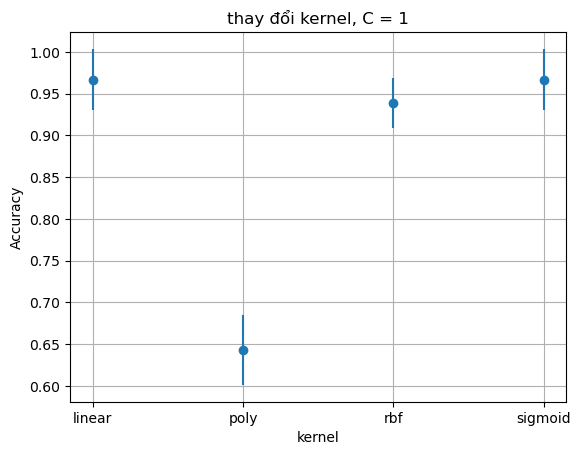

In [45]:
title = "thay đổi kernel, C = 1"
xlabel = "kernel"
X = []
Y = []
error = []

for kernel in tqdm(['linear', 'poly', 'rbf', 'sigmoid']):
    # Với mỗi kernel được chọn, 
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = svm.SVC(kernel=kernel, C=1.0)
    mean, std = cross_validation(text_clf)
    X.append(kernel)
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh 
plot(title, xlabel, X, Y, error)
plt.savefig('images/svm_change_kernel.png', bbox_inches='tight')
plt.show()


## 3.2. Đánh giá ảnh hưởng của tham số C trong SVM

  0%|          | 0/5 [00:00<?, ?it/s]d:\ANACONDA\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
 20%|██        | 1/5 [00:00<00:00,  5.66it/s]d:\ANACONDA\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
 40%|████      | 2/5 [00:00<00:00,  6.16it/s]d:\ANACONDA\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
 60%|██████    | 3/5 [00:00<00:00,  6.36it/s]d:\ANACONDA\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
 80%|████████  | 4/5 [00:00<00:00,  6.49it/s]d:\ANACONDA\Lib\site-packages\sklearn\model_selection\_

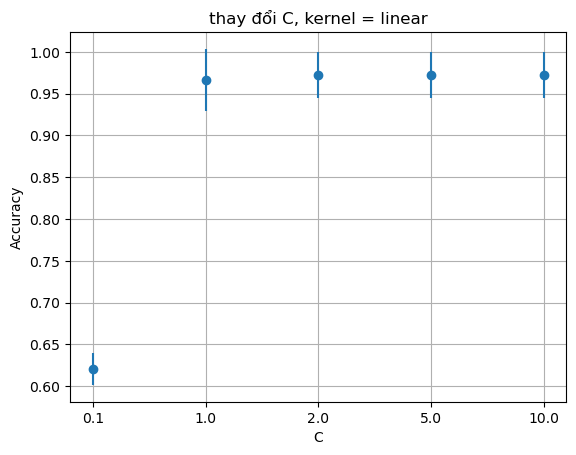

In [46]:
title = "thay đổi C, kernel = linear"
xlabel = "C"
X = []
Y = []
error = []

for C in tqdm([.1, 1.0, 2.0, 5.0, 10.0]):
    # Với từng giá trị C nhận được, 
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = svm.SVC(kernel='linear', C=C)
    mean, std = cross_validation(text_clf)
    X.append(str(C))
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.savefig('images/svm_change_C.png', bbox_inches='tight')
plt.show()


## 3.3. Đánh giá ảnh hưởng của độ đo trong Random Forest

  0%|          | 0/2 [00:00<?, ?it/s]d:\ANACONDA\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
d:\ANACONDA\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 50%|█████     | 1/2 [00:05<00:05,  5.54s/it]d:\ANACONDA\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
100%|██████████| 2/2 [00:08<00:00,  4.36s/it]


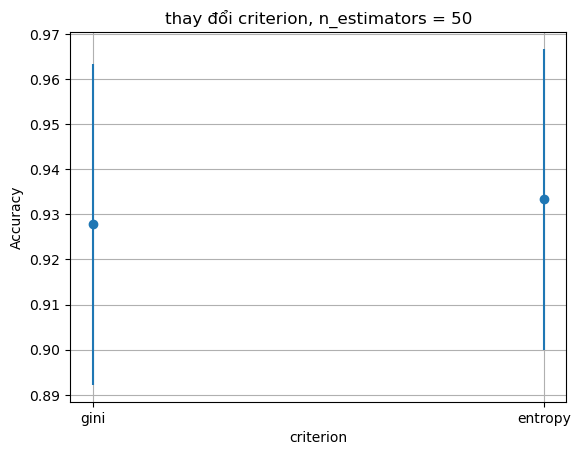

In [48]:
title = "thay đổi criterion, n_estimators = 50"
xlabel = "criterion"
X = []
Y = []
error = []

for criterion in tqdm(["gini", "entropy"]):
    # Với mỗi criterion nhận được,
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = RandomForestClassifier(criterion=criterion, n_estimators=50)
    mean, std = cross_validation(text_clf)
    X.append(str(criterion))
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.savefig('images/RF_change_criterion.png', bbox_inches='tight')
plt.show()


## 3.4. Đánh giá ảnh hưởng của số cây trong Random Forest 

  0%|          | 0/4 [00:00<?, ?it/s]d:\ANACONDA\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
 25%|██▌       | 1/4 [00:02<00:08,  2.69s/it]d:\ANACONDA\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
 50%|█████     | 2/4 [00:05<00:05,  2.56s/it]d:\ANACONDA\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
 75%|███████▌  | 3/4 [00:05<00:01,  1.56s/it]d:\ANACONDA\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
100%|██████████| 4/4 [00:06<00:00,  1.64s/it]


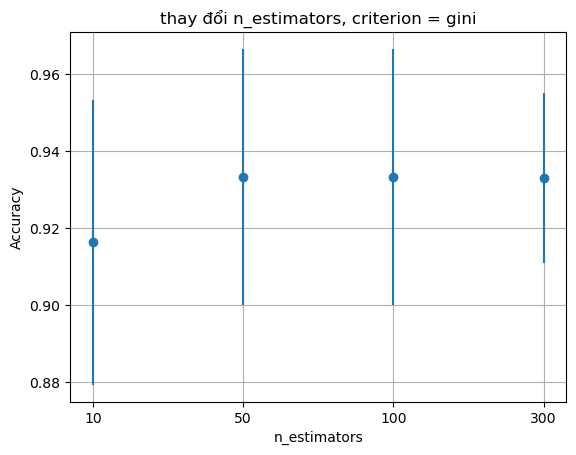

In [49]:
title = "thay đổi n_estimators, criterion = gini"
xlabel = "n_estimators"
X = []
Y = []
error = []

for n_estimators in tqdm([10, 50, 100, 300]):
    # Với từng giá trị n_estimators nhận được,
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = RandomForestClassifier(criterion='gini', n_estimators=n_estimators)
    mean, std = cross_validation(text_clf)
    X.append(str(n_estimators))
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.savefig('images/RF_change_N.png', bbox_inches='tight')
plt.show()


## 3.4. Đánh giá ảnh tham số K trong mô hình KNN

  0%|          | 0/5 [00:00<?, ?it/s]d:\ANACONDA\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
d:\ANACONDA\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
 40%|████      | 2/5 [00:00<00:00, 18.30it/s]d:\ANACONDA\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
d:\ANACONDA\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
d:\ANACONDA\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
100%|███

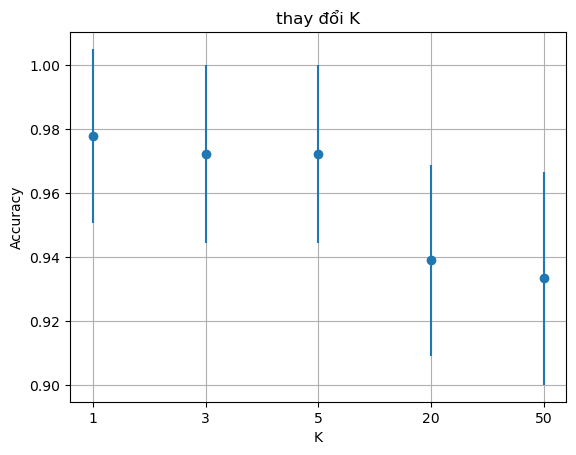

In [50]:
from sklearn.neighbors import KNeighborsClassifier

title = "thay đổi K"
xlabel = "K"
X = []
Y = []
error = []

for k in tqdm([1, 3, 5, 20, 50]):
    # Với từng giá trị k nhận được,
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = KNeighborsClassifier(n_neighbors=k)
    mean, std = cross_validation(text_clf)
    X.append(str(k))
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.savefig('images/KNN_change_K.png', bbox_inches='tight')
plt.show()


# 4. So sánh các mô hình
- Sau khi chọn được các bộ tham số tốt nhất cho mỗi mô hình, ta huấn luyện lại trên toàn bộ tập Train.
- Dùng các mô hình mới huấn luyện để phán đoán cho các dữ liệu trong tập Test
- Đo đạc Độ chính xác (Accuracy) của chúng và so sánh kết quả.

In [51]:
svm_ = svm.SVC(kernel='linear', C=1.0)
rf = RandomForestClassifier(criterion='gini', n_estimators=300)
knn = KNeighborsClassifier(n_neighbors=5)

# Huấn luyện các mô hình trên tập dữ liệu train đầy đủ
svm_.fit(X_train, Y_train)
rf.fit(X_train, Y_train)
knn.fit(X_train, Y_train)


,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [52]:
# Kết quả dự đoán trên tập test
print(f'SVM: {accuracy_score(Y_test, svm_.predict(X_test))}')
print(f'RF: {accuracy_score(Y_test, rf.predict(X_test))}')
print(f'KNN: {accuracy_score(Y_test, knn.predict(X_test))}')

SVM: 0.9111111111111111
RF: 0.8888888888888888
KNN: 0.9555555555555556


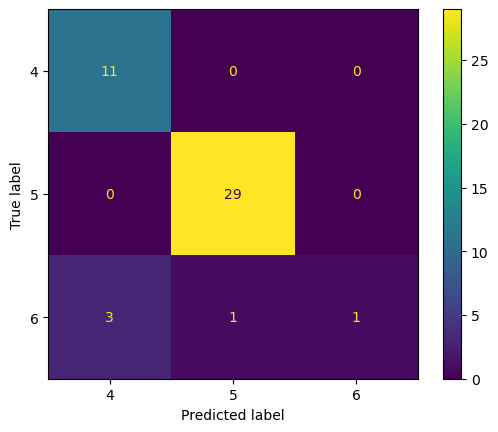

In [58]:
ConfusionMatrixDisplay.from_estimator(svm_, X_test, Y_test)

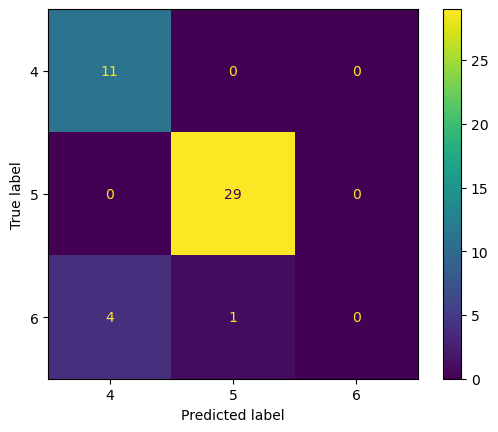

In [59]:
ConfusionMatrixDisplay.from_estimator(rf, X_test, Y_test)

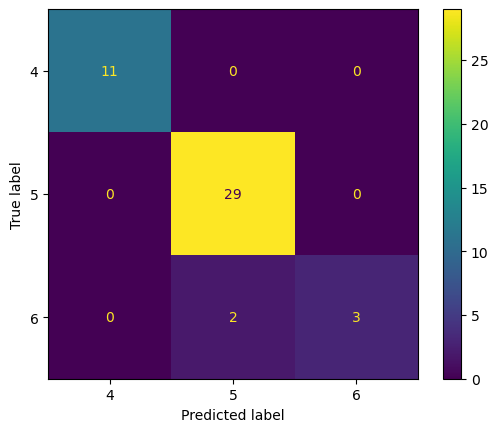

In [60]:
ConfusionMatrixDisplay.from_estimator(knn, X_test, Y_test)

# 5. Bài tập
- Sử dụng dữ liệu đánh giá tín dụng cá nhân
- Sử dụng độ đo đánh giá negative cost
- Lựa chọn tham số cho các mô hình SVM, Random Forest và KNN
- So sánh các mô hình với siêu tham số tốt nhất

In [63]:
data = np.genfromtxt('./data/german.data-numeric')
X_data = data[:,:24]
Y_data = data[:,-1]
print(X_data.shape)
print(Y_data.shape)

(1000, 24)
(1000,)


In [64]:
# Hàm tính neg_cost, dùng để truyền vào scoring của learning_curve
def neg_cost(estimator, X, y):
    y_true = y
    y_pred = estimator.predict(X)
    true_pos = ((y_true==y_pred)&(y_true==1.0))*0.0
    true_ne = ((y_true==y_pred)&(y_true==2.0))*0.0
    false_ne = ((y_true!=y_pred)&(y_true==1.0))*1.0
    false_pos = ((y_true!=y_pred)&(y_true==2.0))*5.0
    return -sum(true_pos + true_ne + false_pos + false_ne)/len(y_true)

In [67]:
def cross_validation(estimator):
    _, train_scores, test_scores = learning_curve(estimator, X_train, Y_train, cv=10, n_jobs=-1, train_sizes=[1.0, ], scoring=neg_cost)
    test_scores = test_scores[0]
    mean, std = test_scores.mean(), test_scores.std()
    return mean, std

def plot(title, xlabel, X, Y, error, ylabel = "Neg_Cost"):
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid()
    plt.ylabel(ylabel)
    
    plt.errorbar(X, Y, error, linestyle='None', marker='o')

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)
print("Dữ liệu training = ", X_train.shape, y_train.shape)
print("Dữ liệu testing = ", X_test.shape, y_test.shape)

Dữ liệu training =  (800, 24) (800,)
Dữ liệu testing =  (200, 24) (200,)


# SVM

100%|██████████| 4/4 [00:08<00:00,  2.04s/it]


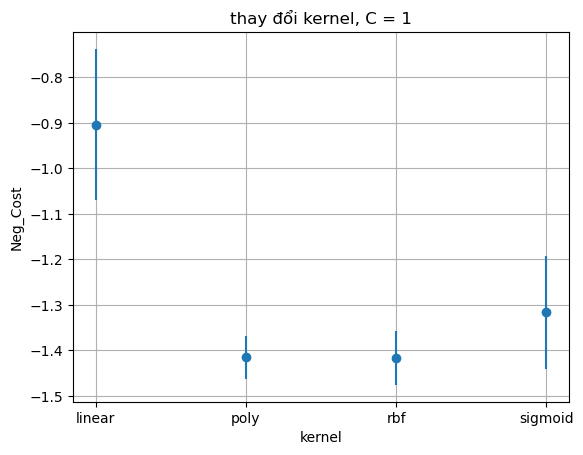

In [68]:
title = "thay đổi kernel, C = 1"
xlabel = "kernel"
X = []
Y = []
error = []

for kernel in tqdm(['linear', 'poly', 'rbf', 'sigmoid']):
    # Với mỗi kernel được chọn, 
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = svm.SVC(kernel=kernel, C=1.0)
    mean, std = cross_validation(text_clf)
    X.append(kernel)
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh 
plot(title, xlabel, X, Y, error)
plt.savefig('images/svm_change_kernel1.png', bbox_inches='tight')
plt.show()


100%|██████████| 5/5 [00:17<00:00,  3.44s/it]


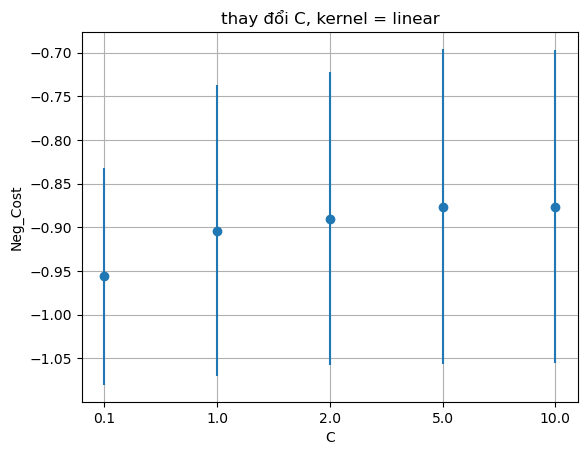

In [69]:
title = "thay đổi C, kernel = linear"
xlabel = "C"
X = []
Y = []
error = []

for C in tqdm([.1, 1.0, 2.0, 5.0, 10.0]):
    # Với từng giá trị C nhận được, 
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = svm.SVC(kernel='linear', C=C)
    mean, std = cross_validation(text_clf)
    X.append(str(C))
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.savefig('images/svm_change_C1.png', bbox_inches='tight')
plt.show()


# RF

100%|██████████| 2/2 [00:00<00:00,  2.93it/s]


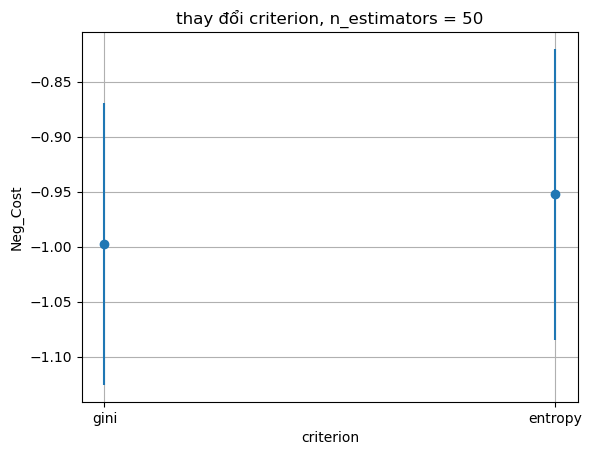

In [70]:
title = "thay đổi criterion, n_estimators = 50"
xlabel = "criterion"
X = []
Y = []
error = []

for criterion in tqdm(["gini", "entropy"]):
    # Với mỗi criterion nhận được,
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = RandomForestClassifier(criterion=criterion, n_estimators=50)
    mean, std = cross_validation(text_clf)
    X.append(str(criterion))
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.savefig('images/RF_change_criterion1.png', bbox_inches='tight')
plt.show()


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


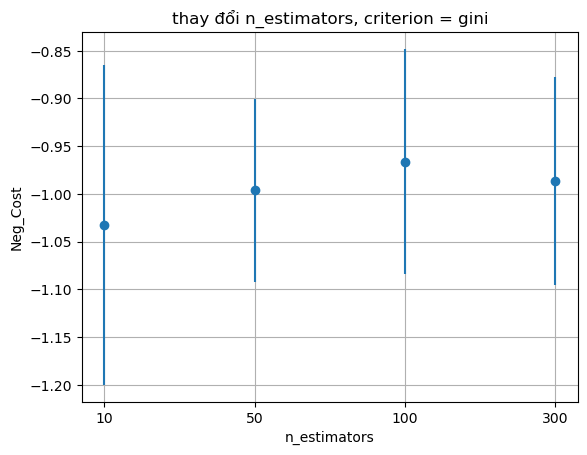

In [72]:
title = "thay đổi n_estimators, criterion = gini"
xlabel = "n_estimators"
X = []
Y = []
error = []

for n_estimators in tqdm([10, 50, 100, 300]):
    # Với từng giá trị n_estimators nhận được,
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = RandomForestClassifier(criterion='gini', n_estimators=n_estimators)
    mean, std = cross_validation(text_clf)
    X.append(str(n_estimators))
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.savefig('images/RF_change_N1.png', bbox_inches='tight')
plt.show()


# KNN

100%|██████████| 5/5 [00:00<00:00,  6.13it/s]


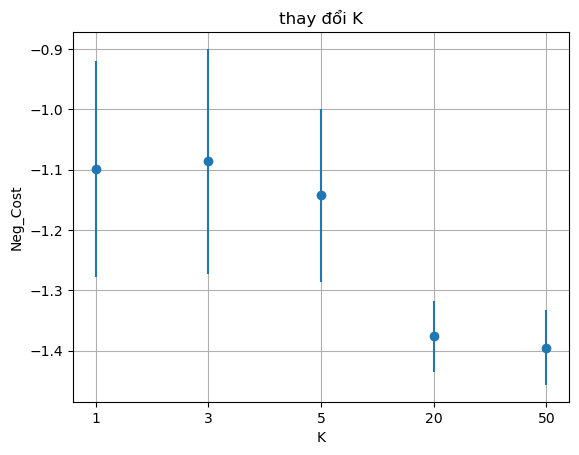

In [73]:
from sklearn.neighbors import KNeighborsClassifier

title = "thay đổi K"
xlabel = "K"
X = []
Y = []
error = []

for k in tqdm([1, 3, 5, 20, 50]):
    # Với từng giá trị k nhận được,
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = KNeighborsClassifier(n_neighbors=k)
    mean, std = cross_validation(text_clf)
    X.append(str(k))
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.savefig('images/KNN_change_K1.png', bbox_inches='tight')
plt.show()


# So sánh


In [76]:
svm_ = svm.SVC(kernel='linear', C=5)
rf = RandomForestClassifier(criterion='entropy', n_estimators=100)
knn = KNeighborsClassifier(n_neighbors=1)

# Huấn luyện các mô hình trên tập dữ liệu train đầy đủ
svm_.fit(X_train, Y_train)
rf.fit(X_train, Y_train)
knn.fit(X_train, Y_train)

,n_neighbors,1
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [77]:
# Kết quả dự đoán trên tập test
print(f'SVM: {neg_cost(svm_, X_test, Y_test)}')
print(f'RF: {neg_cost(rf, X_test, Y_test)}')
print(f'KNN: {neg_cost(knn, X_test, Y_test)}')

SVM: -0.88
RF: -0.865
KNN: -1.065
